In [2]:
#!pip install tensorflow

    100% |████████████████████████████████| 102.7MB 169kB/s ta 0:00:011   19% |██████▎                         | 20.0MB 3.2MB/s eta 0:00:26    22% |███████▏                        | 22.9MB 8.2MB/s eta 0:00:10    29% |█████████▋                      | 30.7MB 4.7MB/s eta 0:00:16
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/76/c2/08685ae86ee1f5a45839e779726640ba981e629da2999ebce17e62639c9a/protobuf-3.10.0-cp36-cp36m-macosx_10_9_intel.whl
    100% |████████████████████████████████| 450kB 6.9MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/3b/72/e6e483e2db953c11efa44ee21c5fdb6505c4dffa447b4263ca8af6676b62/absl-py-0.8.1.tar.gz
    100% |████████████████████████████████| 71kB 4.8MB/s ta 0:00:01
    100% |████████████████████████████████| 3.8MB 2.4MB/s ta 0:00:011    47% |███████████████▏        

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from data_quality import *
import tensorflow as tf
import tensorflow_data_validation as tfdv
import time
import warnings
from tensorflow_metadata.proto.v0 import schema_pb2
warnings.simplefilter('ignore')

In [2]:
clean_flights, dirty_flights = partition_data_files('tmp/FLIGHTS/*.csv')
clean_fb, dirty_fb = partition_data_files('tmp/FBPosts/*.csv')

In [3]:
'''
@description: this is the same function from assignment2; infers schema from a given csv file
@params: csv_file - string csv filepath to read
         column_names - string list, names of the columns along the csv header
@return: schema - inferred schema
'''
def infer_schema_from_csv(csv_file, column_names):
    data_stats = tfdv.generate_statistics_from_csv(data_location=csv_file, column_names=column_names)
    
    #tfdv.visualize_statistics(data_stats)
    schema = tfdv.infer_schema(statistics=data_stats)
    
    return schema 

'''
@description: same function from assignment 2; determines whether the new csv file 
              has anomalies against the schema
@params: csv_file - new csv filepath to compare against schema
         schema - schema against which to compare the new csv file
@return: True - if there are anomalies
          False - if there are no anomalies
'''
def has_anomalies(csv_file, schema, environment='TRAINING'):
    #get column names from passed in schema
    cols = [f.name for f in schema.feature].sort()
    
    options = tfdv.StatsOptions(schema=schema, infer_type_from_schema=True)
    data_stats = tfdv.generate_statistics_from_csv(data_location=csv_file,\
                                                   column_names=cols, stats_options=options)
    
    # Check eval data for errors by validating the eval data stats using the previously inferred schema
    anomalies = tfdv.validate_statistics(statistics=data_stats, schema=schema)
    
    #tfdv.display_anomalies(anomalies)

    if len(anomalies.anomaly_info) > 0:
        return True
    else:
        return False
    
def get_num_anomalies(csv_file, schema, environment='TRAINING'):
    #get column names from passed in schema
    cols = [f.name for f in schema.feature].sort()
    
    options = tfdv.StatsOptions(schema=schema, infer_type_from_schema=True)
    data_stats = tfdv.generate_statistics_from_csv(data_location=csv_file,\
                                                   column_names=cols, stats_options=options)
    
    # Check eval data for errors by validating the eval data stats using the previously inferred schema
    anomalies = tfdv.validate_statistics(statistics=data_stats, schema=schema, environment=environment)
    
    #tfdv.display_anomalies(anomalies)

    return len(anomalies.anomaly_info)

'''
@description: takes the current csv file and updates the passed in schema to include its values as "valid"
@params: csv_file - new csv file to add to the schema
         schema - schema to be updated
@return: updated_schema - new schema with anomalies of csv_file param added
'''
def update_schema(csv_file, schema):
    #get column names from passed in schema
    cols = [f.name for f in schema.feature].sort()
    
    options = tfdv.StatsOptions(schema=schema, infer_type_from_schema=True)
    new_batch_stats = tfdv.generate_statistics_from_csv(data_location=csv_file,\
                                                        column_names=cols, stats_options = options)

    # Check eval data for errors by validating the eval data stats using the previously inferred schema
    updated_schema = tfdv.update_schema(schema, new_batch_stats)
    #tfdv.display_schema(schema=updated_schema)

    return updated_schema

'''
@description: updates the schema for num_files number of files
@params: all_filenames - string list of all csv filenames
         num_files - the number of files we want to include in our "acceptable" schema
@return: updated_schema - new schema with anomalies of all num_files number of csv files added
'''
def acceptable_schema(training_files):
    successful = True
    
    for i, file in enumerate(training_files):
        #print("Reading file: ", file)
        
        #for the first file read in, infer its schema
        if i == 0:
            columns = list(pd.read_csv(file, error_bad_lines=False).columns).sort()
            schema = infer_schema_from_csv(file, columns)
        else:
            schema = update_schema(file, schema) #updated schema
            #sanity check to make sure this is working
            if has_anomalies(file, schema):
                print('Unsuccessful schema update on file number {}: {}'.format(i,file))
                successful = False
                break
                
    if successful:
        print("Schema successfully updated for all {} files".format(len(training_files)))
        
    return schema

In [4]:
def is_acceptable(train_batch, test_batch):
    #set all flags (this is bc what we need to do with TFDV depends on the type of data we're dealing with)
    flights = False
    fb = False
    dirty = False
    #if this is flights data
    if 'FLIGHTS' in test_batch[0]: flights = True
    #if this is facebook data    
    if 'FBPosts' in test_batch[0]: fb = True
        
    #if the test batch is a dirty file
    if 'dirty' in test_batch[0]: dirty = True
    
    ######## now work on updating the schema ####### 
    #update schema with all the files in the train batch
    updated_schema = acceptable_schema(training_files)
    
    #make sure TFDV knows the columns that are only in the clean + not the dirty data
    updated_schema.default_environment.append('TRAINING')
    updated_schema.default_environment.append('TESTING')
    
    #specify that 'for_key' feature is not in TESTING environment
    if dirty and flights:
        tfdv.get_feature(updated_schema, 'for_key').not_in_environment.append('TESTING')
        
    if dirty and fb:
        ### do similar thing here ###
        pass
    

    #get the number of anomalies for the test batch prior to relaxing constraints
    if dirty:
        num_anomalies = get_num_anomalies(test_batch[0], updated_schema, environment='TESTING')
    else: 
        #if it's a clean file, default environment is TRAINING
        num_anomalies = get_num_anomalies(test_batch[0], updated_schema)
    
    #relax constraints for each type of data
    if flights:
        tfdv.get_feature(updated_schema,'ArrivalGate').distribution_constraints.min_domain_mass = 0.8
        tfdv.get_feature(updated_schema,'DepartureGate').distribution_constraints.min_domain_mass = 0.8
    if fb:
        ### do similar thing here ###
        pass
    
    #get anomalies after having relaxed constraints
    if dirty:
        adjusted_num_anomalies = get_num_anomalies(test_batch[0], updated_schema, environment='TESTING')
    else:
        adjusted_num_anomalies = get_num_anomalies(test_batch[0], updated_schema)
    
    ######## determine whether acceptable or not ########
    #my definition of "acceptable" is just if the relaxed constraints had any affect on the anomalies
    #being present (so relaxing constraints should yield less anomalies after adjustment)
    if adjusted_num_anomalies < num_anomalies: 
        return True 
    else:
        return False       

In [122]:
start_time = time.time()
print(is_acceptable(clean_flights[0:5], dirty_flights[5:6]))
print("Finished in: {:.2f} seconds".format(time.time()-start_time))

Schema successfully updated for all 5 files
False
Finished in: 28.64 seconds


In [5]:
flights_analysis = pd.DataFrame(columns=['train_type', 'batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

for train_type in ['rolling', 'increasing']:
    for batch_size in range(1, 10):
        for i in range(len(clean_flights)-batch_size):
            row = analysis(i, train_type, clean_flights, dirty_flights, batch_size)
            flights_analysis.loc[counter] = row
            counter = counter + 1
flights_analysis.to_csv('flights_batch_analysis_tfdv.csv', index = False)

In [6]:
flights_accuracy = get_accuracy(flights_analysis)
flights_accuracy.to_csv('flights_accuracy_tfdv.csv', index = False)

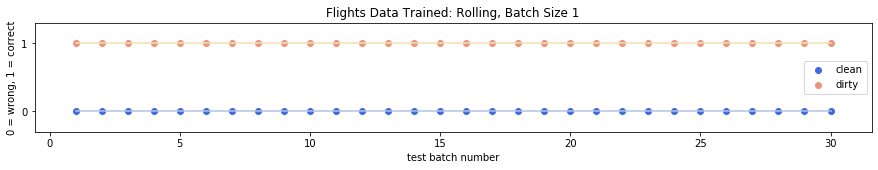

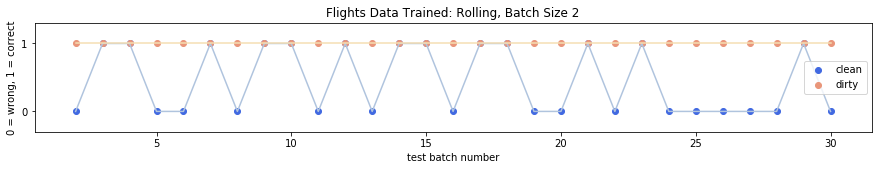

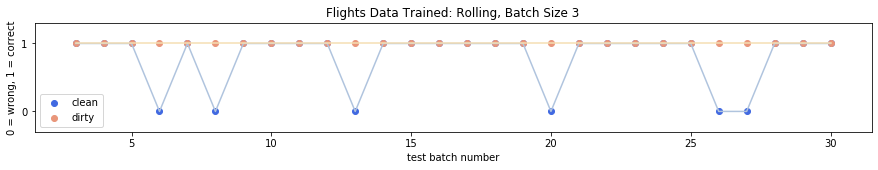

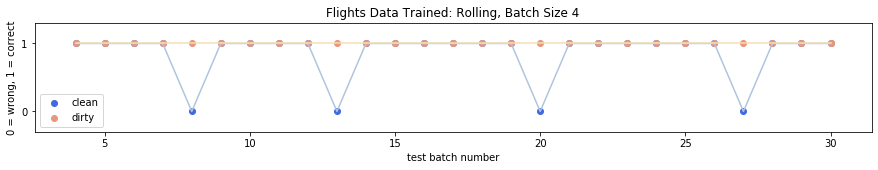

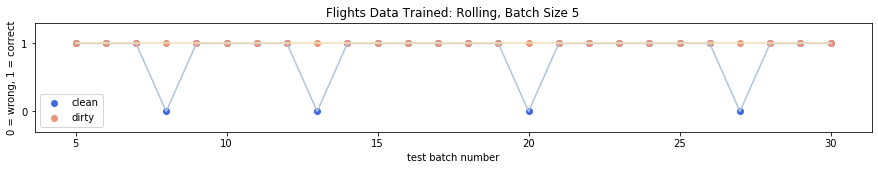

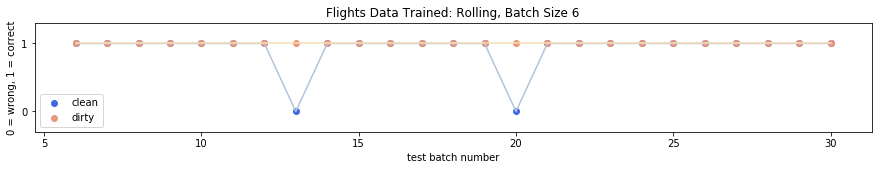

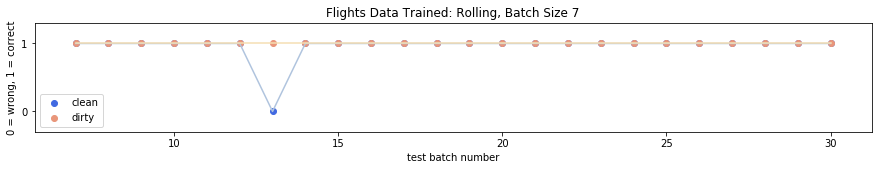

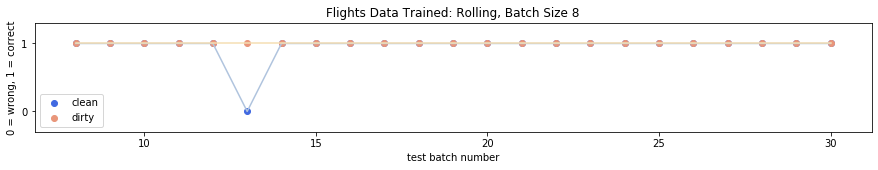

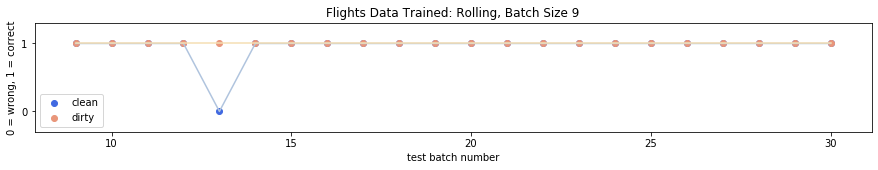

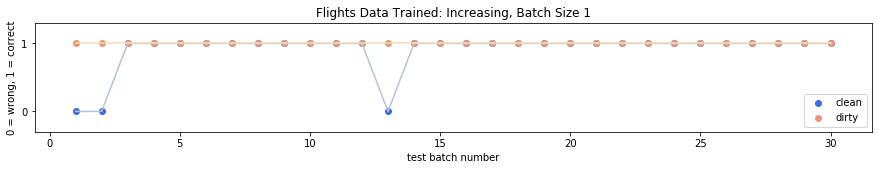

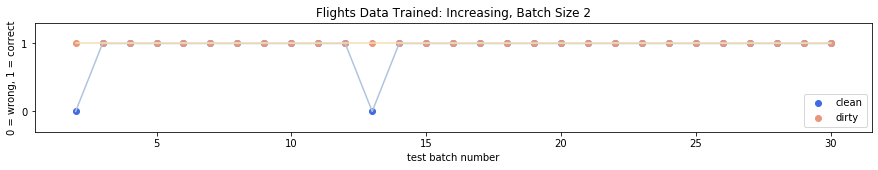

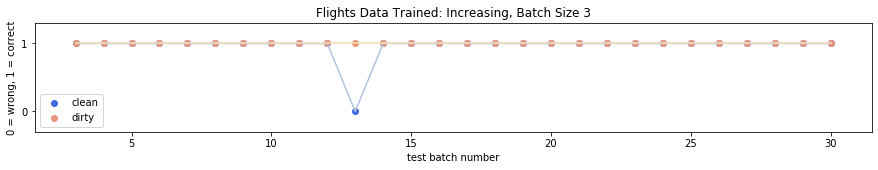

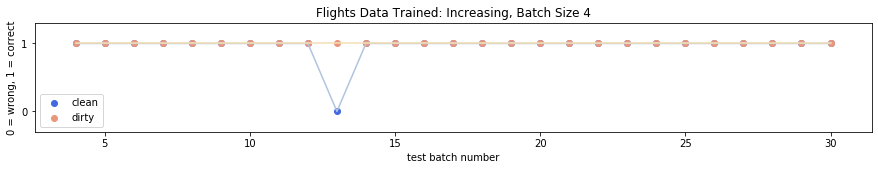

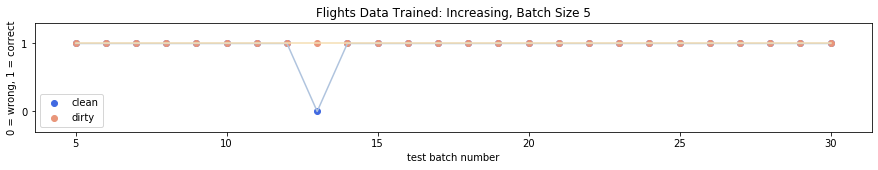

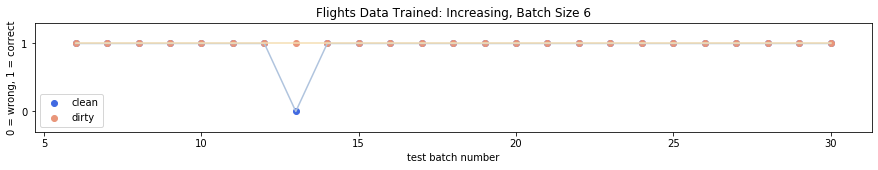

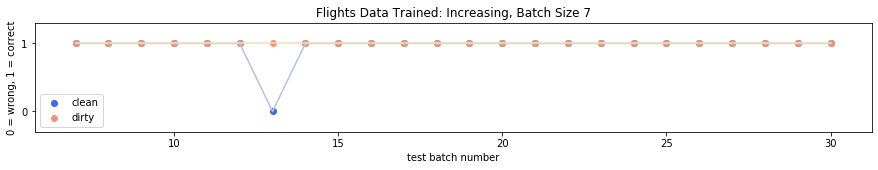

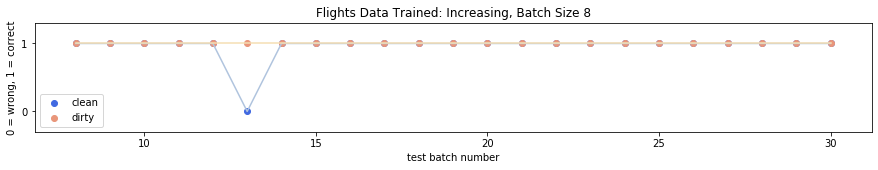

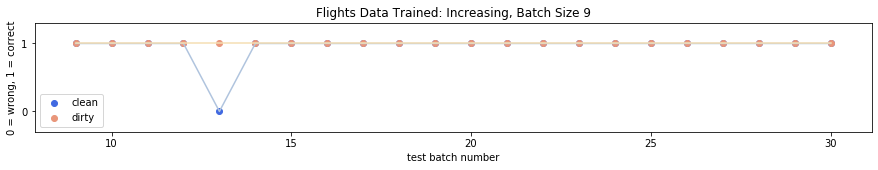

In [7]:
plot_batch('flights', flights_analysis, range(1, 10))